# Tutorial
This tutorial demonstrates how to use CGMega functions with a demo dataset (MCF7 cell line as an example). Once you are familiar with CGMega’s workflow, please replace the demo data with your own data to begin your analysis. 

## How to prepare input data

We recommend getting started with CGMega using the provided demo dataset. When you want to apply CGMega to your own multi-omics dataset, please refer to the following tutorials to learn how to prepare input data.

Overall, the input data consists of two parts: the graph, constructed from PPI and the node feature including condensed Hi-C features, SNVs, CNVs frequencies and epigenetic densities.

If you are unfamiliar with CGMega, you may start with our data used in the paper to save your time. For MCF7 cell line, K562 cell line and AML patients, the input data as well as their label information are uploaded [here](https://github.com/NBStarry/CGMega/tree/main/data). If you start with any one from these data, you can skip the step 1 about How to prepare input data. The following steps from 1.1~1.3 can be found in our source code [data_preprocess_cv.py](https://github.com/NBStarry/CGMega/tree/main/data_preprocess_cv.py).

> The labels should be collected yourself if you choose analyze your own data.

### Import default params and set constants

In [1]:
import utils
import config_load

from data_preprocess_cv import *

configs = config_load.get()

# DATA_DIR should contain 'Breast_Cancer' to run the code. See data_preprocess_cv.get_cell_line().
DATA_DIR = configs['data_dir']
# Set a GPU with enough memory. Set to 'cpu' if you don't have a GPU, but it will be very slow.
GPU_ID = 3
configs["gpu"] = f"cuda:{GPU_ID}"
PPI = configs['ppi']
RANDOM_SEED = configs['random_seed']
CV_FOLDS = configs['cv_folds']
GENE_LIST = utils.get_gene_list(rename=True)
GENE_LIST[:10]

,Gene Name
0,OR4F5
1,SAMD11
2,NOC2L
3,KLHL17
4,PLEKHN1
5,ISG15
6,AGRN
7,C1orf159
8,TTLL10
9,SDF4


If you just want to train the model without rebuild the dataset, skip to [Load data and Train model](#load-data-and-train-model).

### Hi-C data embedding
Before SVD, the Hi-C data should go through: 
1. processing by [NeoLoopFinder](https://github.com/XiaoTaoWang/NeoLoopFinder) to remove the potential effects of structural variation; 
2. normalization using [ICE]( https://bitbucket.org/mirnylab/hiclib) correction to improve the data quality. 
> Demo data had already gone through these steps. Skip to [Hi-C reduction](#hic-reduction).

If you are new to these two tools, please go through these document in advance.
[tutorial for NeoLoopFinder (need link)](./)
[tutorial for Hi-C normalization (need link)](./)

The parameters and main functions used in NeoLoopFinder are listed as below:

---

Parameters:

- input file format: .cool or .mcool
- resolution: 10Kb
- binsize: 10000
- ploidy: 2
- enzymes: MobI
- genome: hg38

Please choose parameters by [NeoLoopFinder](https://github.com/XiaoTaoWang/NeoLoopFinder) to suit your data. An example is available in [batch_neoloop.sh](https://github.com/NBStarry/CGMega/blob/main/data/AML_Matrix/batch_neoloop.sh).

---

Then we implement ICE correction following [Imakaev, Maxim et al.](https://www.nature.com/articles/nmeth.2148) and this step has beed packaged in one-line command as `content from xuxiang`.

<div id="hic-reduction"></div> 

Finally, we get Hi-C matrix for reduction. You can download demo Hi-C matrix from [Google Drive](https://drive.google.com/drive/folders/1w4GGIZRUNevTkWUSsLKPNS5AliHeOvi8?usp=sharing). To get Hi-C embeddings using SVD, run:

In [2]:
# Hi-C matrix should be put into DATA_DIR first.
# Hi-C matrix should be named as "MCF7_Hi-C_Ice" to run the code (download demo from Google Drive). See data_preprocess_cv.get_hic_mat().get_hic_dir()
hic_mat = get_hic_mat(data_dir=DATA_DIR) # this could take serveral minutes (2m 11s on our computer).

hic_df = pd.DataFrame(data=hic_mat, columns=[f'HiC-{i}' for i in range(5)])
hic_df = pd.concat([GENE_LIST, hic_df], axis=1)
hic_df[:10]

Loading Hi-C matrix from data/Breast_Cancer_Matrix/MCF7_Hi-C_Ice ......


,Gene Name,HiC-0,HiC-1,HiC-2,HiC-3,HiC-4
0,OR4F5,1.000000,0.000160,0.224522,0.240360,0.480144
1,SAMD11,0.983034,0.022809,0.215827,0.232253,0.483053
2,NOC2L,0.982147,0.037410,0.187268,0.224593,0.464583
3,KLHL17,1.000000,0.000160,0.224522,0.240360,0.480144
4,PLEKHN1,1.000000,0.000160,0.224522,0.240360,0.480144
5,ISG15,0.990749,0.013589,0.217608,0.228825,0.481511
6,AGRN,0.974280,0.055531,0.190371,0.218615,0.485405
7,C1orf159,0.961529,0.062132,0.185861,0.212024,0.454003
8,TTLL10,0.991588,0.010711,0.215210,0.235848,0.479124
9,SDF4,0.974903,0.039698,0.176009,0.226074,0.492445


### Other omics data
Download demo data from [Google Drive](https://drive.google.com/drive/folders/1w4GGIZRUNevTkWUSsLKPNS5AliHeOvi8?usp=sharing), put it into DATA_DIR, and run:

In [7]:
# Node feature file (download demo from Google Drive) should be put into DATA_DIR first, and should be named as "MCF7-Normalized-Nodefeature-Matrix.csv"
node_feat, pos = get_node_feat(hic_feat=hic_mat, data_dir=DATA_DIR)
feat_cols = ['ATAC-1','CTCF-1','CTCF-2','CTCF-3','H3K4me3-1','H3K4me3-2','H3K27ac-1','H3K27ac-2','Means-SNV','Means-CNV']
feat_cols.extend(['HiC-{}'.format(i) for i in range(hic_mat.shape[1])])
feat_df = pd.DataFrame(data=node_feat, columns=feat_cols)

feat_df = pd.concat([GENE_LIST, feat_df], axis=1)
feat_df[:10]

Feature matrix shape: (16165, 15)


,Gene Name,ATAC-1,CTCF-1,CTCF-2,CTCF-3,H3K4me3-1,H3K4me3-2,H3K27ac-1,H3K27ac-2,Means-SNV,Means-CNV,HiC-0,HiC-1,HiC-2,HiC-3,HiC-4
0,OR4F5,0.529128,0.070841,0.105758,0.225933,0.130488,0.618429,0.482443,0.621274,0.487092,0.180119,1.000000,0.000160,0.224522,0.240360,0.480144
1,SAMD11,0.796776,0.489768,0.365744,0.671051,0.839078,0.884736,0.816900,0.836558,0.150033,0.177968,0.983034,0.022809,0.215827,0.232253,0.483053
2,NOC2L,0.840875,0.235458,0.212696,0.342695,0.854631,0.946797,0.840622,0.827042,0.454941,0.177968,0.982147,0.037410,0.187268,0.224593,0.464583
3,KLHL17,0.799964,0.238202,0.184042,0.433269,0.787226,0.852321,0.726881,0.777425,0.446193,0.177968,1.000000,0.000160,0.224522,0.240360,0.480144
4,PLEKHN1,0.877223,0.391312,0.305844,0.426802,0.840988,0.905411,0.919055,0.841827,0.448487,0.177968,1.000000,0.000160,0.224522,0.240360,0.480144
5,ISG15,0.858863,0.691608,0.716028,0.778756,0.885734,0.916357,0.978684,0.834207,0.391635,0.177968,0.990749,0.013589,0.217608,0.228825,0.481511
6,AGRN,0.866120,0.497205,0.478136,0.686338,0.825454,0.889098,0.930359,0.788913,0.422046,0.179403,0.974280,0.055531,0.190371,0.218615,0.485405
7,C1orf159,0.899884,0.316383,0.242535,0.465516,0.844503,0.893245,0.870405,0.761551,0.255589,0.179403,0.961529,0.062132,0.185861,0.212024,0.454003
8,TTLL10,0.665885,0.355122,0.315340,0.436435,0.304085,0.617047,0.560824,0.671845,0.403230,0.180119,0.991588,0.010711,0.215210,0.235848,0.479124
9,SDF4,0.874973,0.400828,0.283395,0.513313,0.867976,0.940533,0.904143,0.823765,0.417376,0.180119,0.974903,0.039698,0.176009,0.226074,0.492445


### PPI graph construction
Then, we read the PPI data ([Google Drive](https://drive.google.com/drive/folders/1w4GGIZRUNevTkWUSsLKPNS5AliHeOvi8?usp=sharing)) and transform it into a graph through the following commands:

In [8]:
# PPI matrix named as "{PPI_TYPE}_matrix.csv" should be put into data/{PPI_TYPE} first (download demo from Google Drive).
# For example, "data/CPDB/CPDB_matrix.csv"
ppi_mat = get_ppi_mat(ppi_name='CPDB', from_list=False,) # this could take several minutes (2m 7s on our computer).
ppi_mat[20:30, 20:30]

Loading PPI matrix from data/CPDB/CPDB_matrix.csv ......


array([[0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0, 0.7426669999999999, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.7426669999999999, 0.0, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0]], dtype=object)

### Load gene labels

In [9]:
node_lab, labeled_idx = get_label(data_dir=DATA_DIR, )
labeled_lab = [node_lab[i][1] for i in labeled_idx]
print(f"Positive samples: {sum(node_lab)[1]}  Negative samples: {sum(node_lab)[0]}  Unlabeled samples: {len(node_lab) - len(labeled_idx)}")

Positive samples: 358.0  Negative samples: 1581.0  Unlabeled samples: 14226


### Build PyG Data instance

In [10]:
from data_preprocess_cv import build_pyg_data

data = build_pyg_data(node_feat, node_lab, ppi_mat, pos) # this could take several minutes (1m 18s on our computer).
data

Number of edges: 547530, Dimensionality of edge: 1,
Nubmer of nodes: 16165


Data(x=[16165, 15], edge_index=[2, 547530], edge_attr=[547530, 1], y=[16165, 2], pos=[16165], edge_dim=1)

### Do train-test split

25% for test set, 75% for a 10-fold train-valid spilt.

In [11]:
from sklearn.model_selection import train_test_split, StratifiedKFold

train_idx_list, valid_idx_list = [], []
train_valid_idx, test_idx, train_valid_lab, test_lab = train_test_split(
    labeled_idx, labeled_lab, test_size=0.25, stratify=labeled_lab, random_state=RANDOM_SEED)
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)
for train_labeled_idx, valid_labeled_idx in skf.split(train_valid_idx, train_valid_lab):
    valid_idx_list.append([train_valid_idx[i] for i in valid_labeled_idx])
    train_idx_list.append([train_valid_idx[i] for i in train_labeled_idx])

fold = 0
print(f"Fold {fold}  Training set: {len(train_idx_list[fold])}  Valid set: {len(valid_idx_list[fold])}  Test set: {len(test_idx)}")

Fold 0  Training set: 1308  Valid set: 146  Test set: 485


### Create CancerDataset and Save

In [12]:
import pickle

cv_dataset = create_cv_dataset(train_idx_list.copy(), valid_idx_list.copy(), test_idx.copy(), ppi_data=data)
print(cv_dataset[0])
dataset_dir = os.path.join(DATA_DIR, get_cell_line(DATA_DIR)[1:] + f'_{PPI}_dataset.pkl')
print(f'Finished! Saving dataset to {dataset_dir} ......')
with open(dataset_dir, 'wb') as f:
    pickle.dump(cv_dataset, f)

Data(x=[16165, 15], edge_index=[2, 547530], edge_attr=[547530, 1], y=[16165, 2], pos=[16165], edge_dim=1, train_mask=[16165, 10], valid_mask=[16165, 10], test_mask=[16165], unlabeled_mask=[16165], num_classes=2)
Finished! Saving dataset to data/Breast_Cancer_Matrix/MCF7_CPDB_dataset.pkl ......


### Load data and Train model <div id="load-data-and-train-model"></div>
| Item       | Details          |
| ---------- | ---------------- |
| System     | Ubuntu 20.04.1 LTS |
| RAM Memory | 256G               |
| GPU Memory | NVIDIA GeForce RTX, 24G     |

```note
The above table reports our computing details during CGMega development and IS NOT our computing requirement.

If your computer does not satisfy the above, you may try to lower down the memory used during model training by reduce the sampling parameters, the batch size or so on. 

We are going to test CGMega under more scenarios like with different models of GPU or memory limits to update this table.

```

A 10-fold training would cost 41m on our computer.

In [ ]:
from main import get_training_modules, train_model, predict, calculate_metrics, pred_to_df, score_avg_perfomance

# To load dataset from above, set
# configs['stable'] = False
# To use a stable version in the repo, set
configs['stable'] = True
# The two version should be the same by a consistent process.

# set to 'cuda' to use GPU.
configs['device'] = 'cpu'

# Set log_name and logfile to suit your needs, and you will see training details in logfile.
configs['log_name'] = f"{get_cell_line(configs['data_dir'])[1:]}_{configs['ppi']}"
configs['logfile'] = os.path.join(configs["log_dir"], configs["log_name"] + ".txt")

dataset = get_data(configs=configs, stable=configs['stable'])

sum_auprc, sum_auc, sum_acc, sum_f1, sum_tp, train_result = [], [], [], [], [], []
for i in range(CV_FOLDS):
    head_info = True if i == 0 else False
    configs['fold'] = i
    modules = get_training_modules(configs, dataset)
    auprc, auc, acc, f1, tp, new_ckpt = train_model(modules, configs, configs['log_name'], i, head_info,)
    sum_auprc.append(auprc)
    sum_auc.append(auc)
    sum_acc.append(acc)
    sum_f1.append(f1)
    sum_tp.append(tp)
    y_score, y_pred, y_true, y_index = predict(modules['model'], modules['test_loader_list'], configs, new_ckpt)
    acc, cf_matrix, auprc, f1, auc = calculate_metrics(y_true, y_pred, y_score)
    tp = cf_matrix[1, 1]
    with open(configs['logfile'], 'a') as f:
        print("Test AUPRC:{:.4f}, AUROC:{:.4f}, ACC:{:.4f}, F1:{:.4f}, TP:{:.1f}"
            .format(auprc, auc, acc, f1, tp), file=f, flush=True)
    train_result =  pred_to_df(i, train_result, y_index, y_true, y_score)
score_col = [f"score_{i}" for i in range(CV_FOLDS)]
train_result['avg_score'] = train_result[score_col].mean(axis=1)
train_result['pred_label'] = train_result.apply(
    lambda x: 1 if x['avg_score'] > 0.5 else 0, axis=1)
score_avg_perfomance(train_result, score_col, configs['logfile'])

## Interpretation

After prediction, you can do analyses as following to interpret your results.

#### 1. identify the gene module

For each gene, GNNExplainer identified a subgraph G that is most influential to the preiction of its identity from both topological integration and multi-omic information.
This subgraph consists of two parts: 

- i) the core subgraph that consists of the most influential pairwise relationships for cancer gene prediction, and
- ii) the 15-dimension importance scores that quantify the contributions of each gene feature to cancer gene prediction.

```note
The above module identification is calculated at the level of individual genes.
High-order gene modules reported in our work are constructed with the pairwise-connected individual gene modules.
```

Loading dataset from: data/Breast_Cancer_Matrix/MCF7_CPDB_dataset_final.pkl ......
Doing below distrubs: 
 {'add': [], 'remove': [], 'random': []}
Total Edges: 512478
Pred label: 1.0, True label: 1


Explain node BRCA1: 100%|██████████| 500/500 [01:02<00:00,  7.95it/s]


explain/MCF7_CPDB/feature_mask does not exists, creating explain/MCF7_CPDB/feature_mask
explain/MCF7_CPDB/subgraph does not exists, creating explain/MCF7_CPDB/subgraph
explain/MCF7_CPDB/edge_mask does not exists, creating explain/MCF7_CPDB/edge_mask
Total Edges: 413650
Pred label: 1.0, True label: 1


Explain node BRCA2: 100%|██████████| 500/500 [00:48<00:00, 10.32it/s]


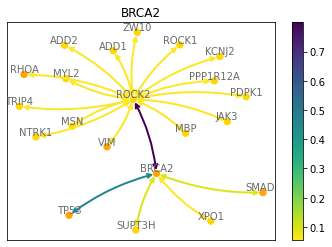

In [6]:
from torch import load
from model import CGMega
from explainer import GATExplainer
from explain_pyg import Batch_Explain, Visualizer

EXPLAIN_DIR = f"explain/{get_cell_line(configs['data_dir'])[1:]}_{configs['ppi']}"
dataset = get_data(configs=configs, stable=configs['stable'])

model = CGMega(
    in_channels=dataset[0].num_node_features, 
    hidden_channels=configs['hidden_channels'], 
    heads=configs['heads'],
    drop_rate=configs['ppi_drop_rate'],
    attn_drop_rate=configs['ppi_attn_drop'],
    edge_dim=1,
    devices_available=configs['gpu'],
    residual=True,
    )

node_list = ['BRCA1', 'BRCA2'] # You can replace this with any interested gene in Gene-Name.txt.
ckpt = 'outs/MCF7_CPDB/best_model.pkl' # You can replace this with any CGMega checkpoint.
model.load_state_dict(load(ckpt)['state_dict'])
explainer = GATExplainer(model=model, epochs=500, num_hops=2, return_type='prob')
task = Batch_Explain(dataset, explainer, node_list, out_dir=EXPLAIN_DIR, normalized='sum', patient=False)
drawer = Visualizer(node_list=node_list, out_dir=EXPLAIN_DIR, fig_name='important_genes', label=task.label)

task.explain(viz_subgraph=True) # this could take several minutes (~5m per gene on our computer).
# There is a very low probability of a bug about loop occurring, the cause of which is not yet known, just re-run the code if you encounter it.

# If you are using docker, you may meet ModuleNotFoundError: No module named 'pygraphviz', and you won't have output in subgraph.

You can find results in EXPLAIN_DIR.


#### 2. calculate the Representative Feature

According to the feature importance scores calculated by GNNExplainer, we defined the representative features (RFs) for each gene as its features with relatively prominent importance scores.
In detail, for a given gene, among its features from ATAC, CTCF, H3K4me3 and H3K27ac, SNVs, CNVs and Hi-C, if a feature is assigned with importance score as 10 times higher than the minimum score,it will be referred to as the RF of this gene.
A graphic illustration is shown as below:

![image](https://github.com/NBStarry/CGMega/blob/main/img/RF_calculation.png)

#### 3. explore the relationships between different gene modules

CGMega serves as a tool to help researchers explore the relationships between individual modules of genes. Such kind of view of high-order gene modules may also helps to find something new.
This is also useful especially when we do not know how to integrate some isolated knowledges into a whole even they are already well-studied under different cases. 

For example, BRCA1 and BRCA2 these two genes act as different roles in common pathway of genome protection and this also exhibited on the topology of their gene modules.
In brief, BRCA1, as a pleiotropic DDR protein working in broad stages of DNA damage response (DDR), was also widely connected with another 20 genes. 
In contrast, BRCA2, as the mediator of the core mechanism of homologous recombination (HR), was connected with other genes via ROCK2, an important gene that directly mediates HR repair.
Moreover, SNV was the RF for both BRCA1 and BRCA2. We also observed a high-order gene module combined from BRCA1 gene module and BRCA2 gene module through three shared genes including TP53, SMAD3 and XPO1.

![image](https://github.com/NBStarry/CGMega/blob/main/img/example.png)